In [16]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import re, nltk, gensim

In [3]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

In [4]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:

df=pd.read_excel("C:\\Users\\Amitabh Tiwari\\ibm-hack\\articles.xlsx")
data=[]

for v in df['content']:
    data.append(v)
print(data[3:4])
#len(data)

['Tip to deal with Fear :We’re all scared of something.  Do you get heart palpitations at the idea of speaking in front of big groups at work? Are you worried you’ll never actually learn to swim? Do you stare at the ceiling, thinking you’ll never write that book you’ve been dreaming about for years?  Me, too. I’ve deeply felt all three of those exact fears, along with many others. But those fears are just a few I’ve started overcoming using a little happiness hack I can share with you.  Are you ready?  O.K., to start with, here is the thought process most of us follow when it comes to facing our fears:  CAN DO IT —> WANT TO DO IT —> DO IT  Before you do anything, you have to feel like you can do it first—and then you have to actually want to do it second.']


In [6]:
#word_tokenizing

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(data))

#print(data_words[:1])

In [7]:
#stop words removal : removing stop words of language=english
#stemming : getting the root words

from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words

p_stemmer = PorterStemmer()
en_stop = get_stop_words('en')

data_lemmatized = []

for i in data_words:
    tokens = i
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    data_lemmatized.append(' '.join(stemmed_tokens))
    
#print(data_lemmatized[:1])
    

In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             #min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=30000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [9]:
#analyzing sparcity : percentage of non-zero data-points in document-word matrix
data_dense = data_vectorized.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.9750354080092136 %


In [12]:
#Building LDA model
lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=2,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=2, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [13]:
#analyzing diagnosis parameters
print("Log Likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))

pprint(lda_model.get_params())

Log Likelihood:  -23071.115748544937
Perplexity:  879.7521705862422
{'batch_size': 2,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 20,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [17]:
#Applying Grid Search to find best LDA model


# Define Search Param
search_params = {'n_components': [3,5,7,9], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [3, 5, 7, 9], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
# Printing params for best model among all the generated ones
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -9603.82768045406
Model Perplexity:  971.103617905369


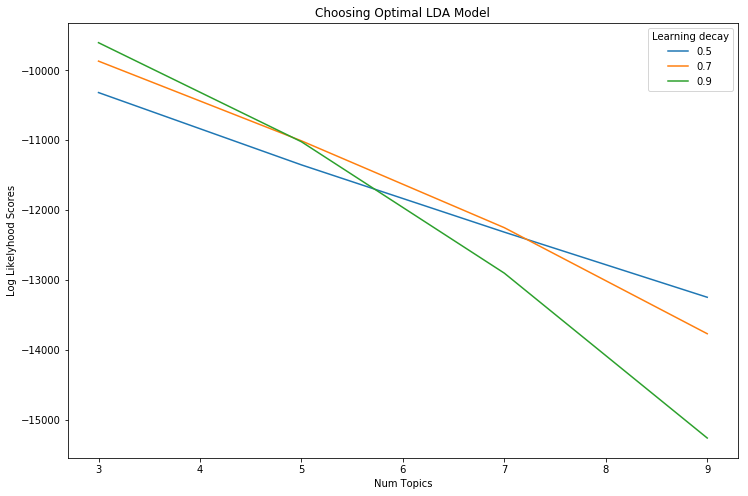

In [19]:
#compare performance scores of models using matploitlib
# Get Log Likelyhoods from Grid Search Output
n_topics = [3,5,7,9]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [21]:
#dominant topic in each doc

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.01,0.01,0.99,2
Doc1,0,0,0.99,2
Doc2,0,0,0.99,2
Doc3,0.01,0.99,0.01,1
Doc4,0,0.99,0,1
Doc5,0,0,0.99,2
Doc6,0.01,0.01,0.98,2
Doc7,0.01,0.99,0.01,1
Doc8,0.01,0.99,0.01,1
Doc9,0.01,0.01,0.98,2


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,2,31
1,1,19
2,0,9


In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer,mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2     -372.142456 -195.243271       1        1  51.206246
1     -437.769562 -443.703552       2        1  31.432671
0     -620.127258 -262.638367       3        1  17.361083, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
214   Default   6.000000         cri   6.000000  30.0000  30.0000
945   Default   7.000000       studi   7.000000  29.0000  29.0000
457   Default  25.000000        help  25.000000  28.0000  28.0000
450   Default   6.000000      health   6.000000  27.0000  27.0000
334   Default   6.000000     exercis   6.000000  26.0000  26.0000
594   Default  10.000000        mani  10.000000  25.0000  25.0000
841   Default  26.000000         sad  26.000000  24.0000  24.0000
242   Default  14.000000     depress  14.000000  23.0000  23.0000
108   Default   5.000000        bodi   5.000000  22.0000  22.0000
742   Default   3.000000  profession   3.000000  21.0000  21.0000
901   Default   5.000000      someon   5.000000  20.0000  20.0000
360   Default  36.000000        fear  36.000000  19.0000  19.0000
299   Default   5.000000      effect   5.000000  18.0000  18.0000
876   Default   7.000000       shown   7.000000  17.0000  17.0000
954   Default   4.000000     suggest   4.000000  16.0000  16.0000
747   Default   2.000000      provid   2.000000  15.0000  15.0000
359   Default   2.000000       fatti   2.000000  14.0000  14.0000
689   Default   4.000000        past   4.000000  13.0000  13.0000
182   Default   2.000000      commun   2.000000  12.0000  12.0000
353   Default   3.000000      famili   3.000000  11.0000  11.0000
949   Default   4.000000     success   4.000000  10.0000  10.0000
1035  Default   5.000000       usual   5.000000   9.0000   9.0000
361   Default  36.000000        feel  36.000000   8.0000   8.0000
1070  Default   4.000000        woke   4.000000   7.0000   7.0000
230   Default  13.000000        deal  13.000000   6.0000   6.0000
54    Default   5.000000         ask   5.000000   5.0000   5.0000
579   Default   6.000000        lose   6.000000   4.0000   4.0000
151   Default   2.000000         chi   2.000000   3.0000   3.0000
513   Default   2.000000    interact   2.000000   2.0000   2.0000
613   Default   3.000000      mental   3.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
1088   Topic3   1.383174        yoga   2.899320   1.0108  -6.0571
726    Topic3   1.021772       power   2.148038   1.0079  -6.3599
1000   Topic3   1.059450       toxin   2.227485   1.0078  -6.3237
340    Topic3   1.027663      expens   2.165778   1.0054  -6.3542
498    Topic3   0.992875    incorpor   2.101262   1.0013  -6.3886
476    Topic3   1.005432       howev   2.128644   1.0009  -6.3761
945    Topic3   3.465187       studi   7.347778   0.9993  -5.1387
108    Topic3   2.337506        bodi   5.767211   0.8478  -5.5324
897    Topic3   1.338644      social   3.007785   0.9414  -6.0898
954    Topic3   1.683782     suggest   4.231835   0.8293  -5.8604
613    Topic3   1.606519      mental   3.968802   0.8465  -5.9074
299    Topic3   2.066636      effect   5.657822   0.7438  -5.6556
457    Topic3   5.358765        help  25.437321   0.1935  -4.7027
876    Topic3   2.406598       shown   7.567334   0.6053  -5.5033
841    Topic3   5.268575         sad  26.691502   0.1284  -4.7197
242    Topic3   3.430171     depress  14.082642   0.3386  -5.1489
361    Topic3   5.060531        feel  36.733479  -0.2313  -4.7600
675    Topic3   3.882178     overcom  24.684376  -0.0988  -5.0251
443    Topic3   2.029259       happi   7.244239   0.4784  -5.6738
994    Topic3   3.609907         tip  34.591605  -0.5090  -5.0978
1035   Topic3   1.746517       usual   5.987090   0.5190  -5.8238
281    Topic3   2.067419         don  13.827366  -0.1494  -5.6552
566    Topic3   1.957665        like 

In [24]:
# defining topic keywords 
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abdomen,abil,abl,absolut,abus,academi,accept,accomplish,accord,account,...,wors,worsen,worthless,wow,write,wrong,www,year,yellow,yoga
Topic0,0.605911,0.621080,0.699753,0.614075,0.546653,0.598405,0.641164,0.619712,0.594675,0.588146,...,0.637057,2.389329,0.703087,0.583808,0.556614,0.559208,0.570977,0.609959,0.611370,2.396541
Topic1,0.622789,1.198479,3.534938,0.547543,1.182509,0.612230,2.857797,0.670544,0.547127,0.630968,...,0.624739,0.632156,0.579477,1.785210,2.437571,1.785731,2.441624,1.168159,0.664371,1.128858
Topic2,1.137761,1.195480,2.405697,1.751575,0.629416,1.154473,5.381602,1.226811,1.227185,1.198032,...,2.423348,0.537768,1.198011,0.664543,0.627196,0.640176,1.830511,0.601302,1.147513,0.564163


In [25]:
#get top 15 keywords for each doc


# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,help,sad,feel,cri,overcom,tip,studi,depress,exercis,health,shown,bodi,don,effect,happi
Topic 1,tip,fear,mani,deal,overcom,feel,sad,peopl,experi,just,want,joy,depress,think,someon
Topic 2,fear,feel,tip,help,sad,overcom,life,thing,time,like,make,anger,don,experi,joy


In [26]:
#Given a piece of text, predicting the topic in document

def predict_topic(text):
    global sent_to_words
    
    mytext_2 = list(sent_to_words(text))
    #print(mytext_2)
    
    mytext_3 =[]
     
    for i in mytext_2 :
        
        tokens=i
        stopped_tokens = [i for i in tokens if not i in en_stop]
        #print(stopped_tokens)
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        #print(stemmed_tokens)
        mytext_3.append(' '.join(stemmed_tokens))
        #print(mytext_3)
    
        mytext_4 = vectorizer.transform(mytext_3)
    
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores


mytext = ["how to overcome Fear.Feeling worried"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
    
    

['fear', 'feel', 'tip', 'help', 'sad', 'overcom', 'life', 'thing', 'time', 'like', 'make', 'anger', 'don', 'experi', 'joy']


In [32]:
#Given a piece of Text, predicting the documents that are related to it most closely

from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = data, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

# Get similar documents

mytext = ["how to maintain Joy.Feeling happy.Glad "]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=5, verbose=True)
print('\n', docs[4][:700])
print('\n\n', docs[3][:500])
#print('\n\n', docs[2][:500])
#print('\n\n', docs[1][:500])
#print('\n\n', docs[0][:500])



Topic KeyWords:  ['fear', 'feel', 'tip', 'help', 'sad', 'overcom', 'life', 'thing', 'time', 'like', 'make', 'anger', 'don', 'experi', 'joy']
Topic Prob Scores of text:  [[0.1 0.1 0.8]]
Most Similar Doc's Probs:   [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

 Tip to Overcome Anger : Take a timeout Timeouts aren't just for kids. Give yourself short breaks during times of the day that tend to be stressful. A few moments of quiet time might help you feel better prepared to handle what's ahead without getting irritated or angry.


 Tip to Overcome Sadness : Shower or bathe in warm water. Research has shown that physical warmth has a comforting effect. Taking a warm bath or a hot shower will help you relax. It may also help you soothe your feelings of sadness
